## Importing the required libraries

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import os
from keras import regularizers

In [5]:
%pylab inline
import pandas as pd
import librosa
import glob 
from keras.callbacks import EarlyStopping
from pathlib import Path

Populating the interactive namespace from numpy and matplotlib


## Link to dataset

https://tuenl.sharepoint.com/sites/gad_cbo/JPC/MC/ESA%20PDEng%20ST%20Project/Forms/AllItems.aspx?viewid=235c9f56%2Db4dc%2D418e%2D8800%2Dd0cde58fff30&id=%2Fsites%2Fgad%5Fcbo%2FJPC%2FMC%2FESA%20PDEng%20ST%20Project%2FModelsAndData%2FAudio%2FDevelopment%2Fdata%2Ftone%5Fcnn%5Fhappy%5Fangry%5Fdataset

In [10]:
# Walking a directory tree and getting the names and directories of the train and test files 
mydiclist={}
curr_path = os.getcwd()
crr_path = Path(curr_path)
parent_path = crr_path.parent
base_path= str(parent_path)+'\\data\\tone_cnn_8_emotions_dataset\\'
for dirpath, dirnames, files in os.walk(base_path):
    for file_name in files:
        if file_name.endswith('.wav'):
            mydiclist[file_name]= dirpath

In [4]:
#from pathlib import Path
#curr_path = os.getcwd()
#crr_path = Path(curr_path)
#parent_path = crr_path.parent
#path = str(parent_path) +  '\\Actor_01\\'
#mylist= os.listdir(path)
#print(type(mylist))

## Setting the labels

In [12]:
feeling_list=[]
       
# (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).        
        
feeling_list=[]
for key in mydiclist:    
    if key[6:-16]=='01':
        feeling_list.append('neutral')
    if key[6:-16]=='02':
        feeling_list.append('calm')
    elif key[6:-16]=='03':
        feeling_list.append('Happy')
    elif key[6:-16]=='04':
        feeling_list.append('sad')
    elif key[6:-16]=='05':
        feeling_list.append('angry')
    elif key[6:-16]=='06':
        feeling_list.append('fearful')
    elif key[6:-16]=='07': 
        feeling_list.append('disgust')
    elif key[6:-16]=='08': 
        feeling_list.append('surprised')
   

In [13]:
labels = pd.DataFrame(feeling_list)

In [14]:
labels[:]

,0
0,neutral
1,neutral
2,neutral
3,neutral
4,calm
...,...
1435,surprised
1436,surprised
1437,surprised
1438,surprised


## Getting the features of audio files using librosa

In [15]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for key in mydiclist:
    X, sample_rate = librosa.load(mydiclist[key]+'\\'+key, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13),
                        axis=0)
    feature = mfccs
    #[float(i) for i in feature]
    df.loc[bookmark] = [feature]
    bookmark=bookmark+1    

In [9]:
#df = pd.DataFrame(columns=['feature'])
#bookmark=0
#for index,y in enumerate(mylist):
#    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
#        X, sample_rate = librosa.load(path+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
#        sample_rate = np.array(sample_rate)
#        mfccs = np.mean(librosa.feature.mfcc(y=X, 
#                                            sr=sample_rate, 
#                                            n_mfcc=13),
#                        axis=0)
#        feature = mfccs
#        #[float(i) for i in feature]
#        df.loc[bookmark] = [feature]
#        bookmark=bookmark+1        

In [16]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [17]:
newdf = pd.concat([df3,labels], axis=1)

In [18]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [19]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
556,-40.868244,-40.850235,-41.051182,-42.040676,-41.906624,-42.173893,-42.314030,-42.772923,-42.436810,-41.787357,...,-37.163662,-36.941036,-37.893730,-38.665417,-40.015690,-40.342216,-41.131241,-40.829308,-39.283112,Happy
1391,-69.113541,-69.209686,-69.547028,-70.108955,-69.749748,-69.453232,-69.459572,-69.053902,-69.248398,-69.290924,...,-39.795837,-39.722858,-39.037891,-38.003288,-38.770657,-39.062130,-40.646812,-35.852226,-29.901733,calm
276,-62.398441,-60.504990,-56.733547,-56.245003,-58.034214,-60.989967,-60.551018,-60.285442,-61.149773,-60.055134,...,-56.053749,-58.752724,-58.840515,-56.561905,-56.074787,-57.301594,-60.498665,-56.931389,-55.152542,fearful
316,-47.663139,-47.677933,-47.639645,-47.585575,-47.357380,-47.152390,-46.562134,-45.171509,-44.318325,-44.852592,...,-40.152534,-41.010311,-40.839897,-41.635464,-41.761421,-41.185459,-41.830139,-44.060730,-44.244770,Happy
434,-56.585148,-56.564571,-58.081631,-57.197670,-58.286541,-55.152973,-54.375668,-53.642071,-52.773014,-54.717468,...,-53.752441,-54.538799,-54.457088,-51.936623,-53.098225,-53.586063,-50.853802,-50.650845,-51.127117,Happy
672,-62.272724,-62.272724,-62.272724,-62.272724,-62.117855,-62.075588,-62.094063,-61.882729,-60.509590,-59.287128,...,-45.572819,-45.240074,-46.185425,-47.669369,-48.715408,-48.083855,-48.970730,-49.335423,-49.601597,Happy
461,-44.614815,-44.014492,-43.963921,-44.872704,-44.159843,-43.476006,-44.777184,-44.895039,-43.643867,-44.021202,...,-40.643650,-41.052246,-40.560001,-41.751423,-41.309448,-42.248558,-43.151108,-42.181381,-42.301792,fearful
176,-54.381008,-54.381008,-54.381008,-54.381008,-54.381008,-54.381008,-54.381008,-54.381008,-54.381008,-54.199749,...,-52.160133,-52.773781,-51.492672,-53.047791,-53.344337,-53.515053,-52.464432,-53.100693,-52.297337,surprised
455,-45.032219,-44.949280,-44.600506,-45.753418,-44.904739,-45.171684,-45.176498,-44.742897,-44.610954,-43.578369,...,-47.246952,-45.484615,-45.256912,-45.362705,-44.978279,-44.990330,-43.417442,-44.386292,-45.165951,angry
810,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,...,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.585144,-54.452507,angry


In [20]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [21]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [22]:
train[10:20]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1377,-52.031616,-52.031616,-52.031616,-52.031616,-51.992802,-51.845150,-51.916653,-52.010750,-52.031616,-52.031616,...,-51.840816,-52.031616,-52.031616,-52.031616,-52.031616,-52.031616,-52.031616,-52.031616,-52.031616,surprised
811,-55.560707,-55.560707,-55.560707,-55.560604,-55.560707,-55.560707,-55.560707,-55.560707,-55.560707,-55.560707,...,-42.873928,-43.580772,-45.323105,-46.200279,-47.405785,-49.732071,-53.589596,-54.522129,-54.791355,angry
718,-54.555088,-53.312748,-52.499714,-52.153812,-53.225159,-54.862038,-53.853035,-52.124130,-50.751213,-50.744629,...,-45.272015,-44.666607,-47.122864,-48.008343,-49.369385,-50.246319,-48.689087,-49.357666,-51.274532,surprised
1241,-52.758724,-52.758724,-51.898464,-49.913265,-49.358860,-49.977512,-50.269756,-49.357018,-50.710350,-52.070847,...,-31.759768,-29.112810,-30.303551,-34.929649,-35.643738,-36.025158,-38.403267,-43.493160,-42.363194,fearful
447,-47.722557,-48.952560,-49.958557,-49.989277,-48.196934,-48.491875,-50.243282,-48.019173,-46.166927,-48.974724,...,-47.571426,-47.346169,-47.848518,-49.430832,-50.582539,-49.161339,-49.113132,-50.099800,-47.463356,sad
1131,-48.999531,-48.506783,-48.756821,-50.473869,-51.650383,-50.362892,-48.454281,-50.036034,-51.698441,-52.403137,...,-37.844307,-39.273209,-39.462620,-40.825439,-35.862583,-30.979042,-27.991926,-27.480709,-24.292814,disgust
334,-42.465012,-42.583298,-43.101849,-43.019978,-42.306850,-41.415932,-40.329880,-40.658188,-41.503643,-42.401058,...,-29.760683,-26.804274,-24.726421,-25.497475,-27.301413,-27.844868,-30.855257,-20.573429,-11.128963,angry
844,-64.247620,-64.373116,-63.817059,-60.828506,-58.402481,-51.610939,-51.796608,-52.992569,-54.142094,-52.943970,...,-47.849430,-48.964546,-48.379604,-47.041023,-46.480042,-46.190392,-46.501640,-46.433926,-47.593559,calm
1358,-59.178349,-59.178349,-59.178349,-59.164715,-58.260948,-57.035988,-57.798237,-58.676754,-59.178349,-59.178349,...,-59.178349,-59.178349,-59.178349,-59.178349,-59.178349,-59.178349,-59.178349,-59.178349,-59.178349,fearful
398,-58.545326,-59.202477,-60.137028,-62.037025,-62.147953,-61.235847,-61.505291,-61.574955,-61.505375,-60.495136,...,-62.534832,-63.489986,-63.011314,-60.754578,-60.942257,-61.236050,-61.601963,-60.400120,-60.975517,fearful


In [23]:
trainfeatures = train.iloc[:, :-1]

In [24]:
trainlabel = train.iloc[:, -1:]
print(shape(trainlabel))

(1152, 1)


In [25]:
testfeatures = test.iloc[:, :-1]

In [26]:
testlabel = test.iloc[:, -1:]

In [27]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)
print(y_train)
lb = LabelEncoder()

nb_classes = 8 
encoder = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train), nb_classes)
y_test = np_utils.to_categorical(lb.fit_transform(y_test), nb_classes)

numpy.save('encoder.npy', lb.classes_)

[['Happy']
 ['calm']
 ['fearful']
 ...
 ['calm']
 ['angry']
 ['angry']]


C:\Users\20194998\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [28]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
X_train.shape

(1152, 216)

## Changing dimension for CNN model

In [31]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [32]:
model = Sequential()
#filters, kernel_size, strides=1, padding='valid', data_format='channels_last',

model.add(Conv1D(256, 5,padding='same', input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax')) #softmax as we are doing multiclass classification
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           8

In [34]:
model.compile(loss=
             'categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
#tf.keras.losses.SparseCategoricalCrossentropy()
#'categorical_crossentropy'

In [35]:
#es = EarlyStopping(monitor='loss', mode='min')
#cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test), callbacks=[es])

In [37]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=5, validation_data=(x_testcnn, y_test))

Epoch 1/5
72/72 [==============================] - 3s 45ms/step - loss: 1.9646 - accuracy: 0.2352 - val_loss: 1.9638 - val_accuracy: 0.2569
Epoch 2/5
72/72 [==============================] - 3s 45ms/step - loss: 1.9092 - accuracy: 0.2812 - val_loss: 1.9572 - val_accuracy: 0.2292
Epoch 3/5
72/72 [==============================] - 3s 45ms/step - loss: 1.8657 - accuracy: 0.3047 - val_loss: 1.9151 - val_accuracy: 0.2674
Epoch 4/5
72/72 [==============================] - 3s 46ms/step - loss: 1.8111 - accuracy: 0.3047 - val_loss: 1.8883 - val_accuracy: 0.2639
Epoch 5/5
72/72 [==============================] - 3s 44ms/step - loss: 1.7906 - accuracy: 0.3038 - val_loss: 1.8483 - val_accuracy: 0.2569


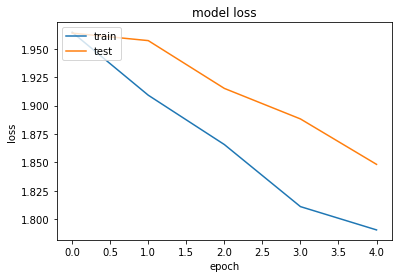

In [38]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [39]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at D:\Projects\ESA\audio-sentiment-analysis\prototypes\saved_models\Emotion_Voice_Detection_Model.h5 


In [40]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [41]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 25.69%


## Predicting emotions on the test data

In [42]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

9/9 [==============================] - 0s 17ms/step


In [43]:
preds

array([[0.16879869, 0.02109269, 0.183692  , ..., 0.10259657, 0.22244832,
        0.09629356],
       [0.23596318, 0.10923008, 0.0417158 , ..., 0.03229681, 0.06905668,
        0.26862612],
       [0.10233006, 0.61442405, 0.06422991, ..., 0.01306609, 0.02684782,
        0.05012532],
       ...,
       [0.22926757, 0.07640006, 0.06560344, ..., 0.02389086, 0.18495321,
        0.16268146],
       [0.1790455 , 0.37358436, 0.04318428, ..., 0.03698333, 0.04661356,
        0.16054548],
       [0.24608195, 0.08227899, 0.10976911, ..., 0.05919385, 0.18360728,
        0.14945805]], dtype=float32)

In [44]:
preds1=preds.argmax(axis=1)

In [45]:
preds1

array([6, 7, 1, 6, 0, 7, 1, 2, 1, 0, 2, 3, 0, 7, 0, 7, 3, 3, 2, 2, 1, 3,
       7, 7, 0, 2, 7, 2, 3, 6, 7, 2, 6, 2, 6, 7, 0, 0, 6, 1, 7, 0, 0, 3,
       6, 6, 3, 2, 1, 1, 6, 2, 7, 3, 0, 7, 3, 0, 0, 2, 7, 2, 0, 3, 6, 2,
       3, 3, 0, 0, 7, 0, 7, 6, 2, 1, 0, 0, 3, 0, 6, 1, 7, 2, 2, 0, 0, 2,
       7, 7, 6, 0, 7, 0, 7, 7, 1, 2, 2, 0, 6, 0, 2, 3, 2, 3, 7, 0, 0, 2,
       7, 0, 2, 2, 0, 6, 6, 2, 0, 0, 6, 0, 3, 0, 0, 1, 0, 1, 2, 1, 0, 2,
       2, 2, 7, 2, 6, 0, 0, 3, 2, 0, 3, 0, 6, 0, 7, 0, 1, 2, 0, 3, 6, 0,
       3, 2, 2, 0, 2, 7, 0, 2, 2, 7, 2, 0, 0, 7, 0, 2, 2, 0, 3, 0, 1, 7,
       7, 7, 3, 7, 0, 2, 3, 2, 0, 7, 1, 0, 2, 2, 0, 0, 0, 2, 3, 6, 6, 7,
       2, 0, 6, 2, 0, 3, 2, 7, 0, 0, 2, 2, 0, 3, 0, 3, 7, 1, 0, 6, 0, 0,
       0, 2, 0, 0, 0, 7, 2, 0, 0, 0, 6, 2, 0, 2, 0, 0, 0, 3, 7, 0, 7, 0,
       6, 6, 0, 7, 0, 0, 2, 3, 1, 0, 6, 0, 2, 2, 2, 0, 0, 0, 6, 7, 6, 3,
       0, 0, 2, 7, 3, 3, 1, 0, 0, 7, 0, 2, 0, 0, 6, 3, 7, 7, 3, 2, 7, 0,
       1, 0], dtype=int64)

In [46]:
abc = preds1.astype(int).flatten()

In [47]:
predictions = (lb.inverse_transform((abc)))

In [48]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf

,predictedvalues
0,sad
1,surprised
2,angry
3,sad
4,Happy
...,...
283,calm
284,surprised
285,Happy
286,angry


In [49]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [50]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf

,actualvalues
0,Happy
1,angry
2,angry
3,sad
4,fearful
...,...
283,Happy
284,fearful
285,fearful
286,angry


In [51]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [52]:
finaldf[0:4]

,actualvalues,predictedvalues
0,Happy,sad
1,angry,surprised
2,angry,angry
3,sad,sad


In [53]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
Happy,39
angry,42
calm,33
disgust,41
fearful,48
neutral,18
sad,35
surprised,32


In [54]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
Happy,96
angry,20
calm,61
disgust,34
sad,31
surprised,46


In [55]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

## you could find this track on below link:

https://tuenl.sharepoint.com/sites/gad_cbo/JPC/MC/ESA%20PDEng%20ST%20Project/Forms/AllItems.aspx?viewid=235c9f56%2Db4dc%2D418e%2D8800%2Dd0cde58fff30&id=%2Fsites%2Fgad%5Fcbo%2FJPC%2FMC%2FESA%20PDEng%20ST%20Project%2FModelsAndData%2FAudio%2FDevelopment%2Fdata%2Ftone%5Fcnn%5Fhappy%5Fangry%5Fdataset%5Fsample%5Fprediction%5Ftracks

In [60]:
# Walking a directory tree and getting the names and directories of the prediction files
mydiclist={}
curr_path = os.getcwd()
crr_path = Path(curr_path)
parent_path = crr_path.parent
base_path= str(parent_path)+'\\data\\tone_cnn_prediction_dataset\\'
for dirpath, dirnames, files in os.walk(base_path):
    for file_name in files:
        if file_name.endswith('.wav'):
            mydiclist[file_name]= dirpath

    
#X, sample_rate = librosa.load(str(base_path) +'\\Recording_hateYou.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
#sample_rate = np.array(sample_rate)
#mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
#featurelive = mfccs
#livedf2 = featurelive

In [61]:
for key in mydiclist:
    X, sample_rate = librosa.load(mydiclist[key]+'\\'+key, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    featurelive = mfccs
    livedf2 = featurelive
    livedf2= pd.DataFrame(data=livedf2)
    livedf2 = livedf2.stack().to_frame().T
    twodim= np.expand_dims(livedf2, axis=2)
    livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)
    livepreds1=livepreds.argmax(axis=1)
    liveabc = livepreds1.astype(int).flatten()
    livepredictions = (lb.inverse_transform((liveabc)))
    print(key+"  :  "+ livepredictions)
    

1/1 [==============================] - 0s 2ms/step
['multiple_silence_trimmed.wav  :  fearful']
1/1 [==============================] - 0s 997us/step
['Recording_hateYou.wav  :  surprised']
